In [1]:
import os

os.environ['CUDA_VISIBLE_DEVICES'] = ''
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU')
print(physical_devices)
# assert len(physical_devices) == 3
# to allow other tensorflow processes to use the gpu
# https://stackoverflow.com/a/60699372/7989988
# tf.config.experimental.set_memory_growth(physical_devices[0], True)
# tf.config.experimental.set_memory_growth(physical_devices[1], True)
# tf.config.experimental.set_memory_growth(physical_devices[2], True)

import numpy as np
from tensorflow import keras
from tensorflow.keras import Model, Input, layers
from IPython.display import display
import tensorflow_datasets as tfds
import time
import matplotlib.pyplot as plt
import enlighten
import tensorflow_probability as tfp
from dotmap import DotMap

[]


In [2]:
import models
import training
import datasets
import vizualization
import schedules

# todo
# - combine shuffled and unshuffled datasets into same thing
# - add extra shuffled indices and noise
# - add "noise fraction" parameter which can be changed the same way as the "n" parameter.
# - add different amounts of noise to the data and see what happens

In [6]:
config = DotMap({
    'ds': 'mnist',
    'distributed': False,
    'minibatch_size': 8,
    'n_steps': 120001,
    'test_size': 300,
    'test_minibatch_size': 25,
    'test_interval': 500,
    'test_n_shuf': [392, 1, 64, 128, 256],
    'test_n_seq': [392, 1, 128, 256, 512],
    'test_autoregressive': False,
    'noise_fraction': 0,
    'display_images': True,
    'display_image_interval': 5000,
    'dont_display_until_loss': 0.48,
    'bg_color': [1.0, 0.4, 0.6],
    'lr_schedule': ['constant', 0.0004],
    'lr_warmup': 100,
    'grad_accum_steps': None, #['exponential', 1, 4],
    'max_accum_steps': 4,
    'use_wandb': True,
    'wandb_log_interval': 10,
    'loss_window_size': 80,
    'kmeans_batch_size': 1000,
})

# need to change for multiworkerstrategy
if config.distributed:
    config.num_devices = len(physical_devices)
else:
    config.num_devices = 1
config.global_batch_size = config.minibatch_size * config.num_devices

Example integers sampled from gamma distribution.
tf.Tensor(
[337 155 233 147 185 201  57 321 404  36  85 162 602  10 350 136  48 254
  50 247  79  63  57  78 156  48  91  31 170 783 164 198 243  89 403 175
  60 211  34  27  38 397  79  28   8 681 302  48 353  23 104 290 175 108
  29 106 378 118 133 783 161  22  40 210 188  83  72 160 150 163 129 334
 148 523 249  33  44 157  61  71  23  90 155 368 115 333  38  86 129 182
   9  60 161 249  13 471  70  87 176 286], shape=(100,), dtype=int32)


centroids.shape (4, 1)


Not using gradient accumulation


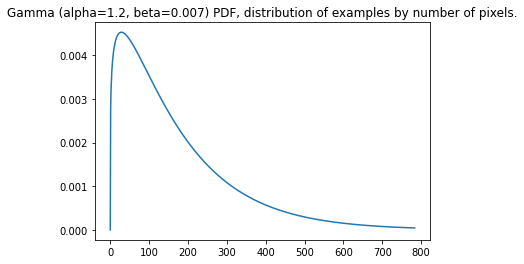

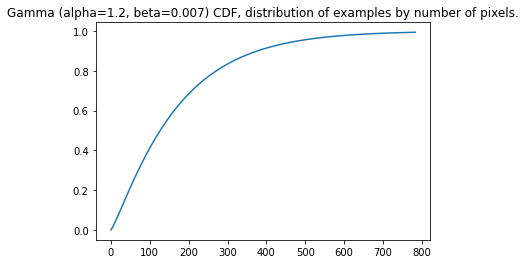

In [7]:
# idea is to not have to re-run this cell for subsequent training runs unless the centroids change

ds_configs = DotMap({
    'mnist': {
        'buffer_size': 60000,
        'name': 'mnist',
        'n_colors': 4,
        'n_color_dims': 1,
        'image_size': (28, 28),
    },
    'mnist_7x7': {
        'buffer_size': 60000,
        'name': 'mnist',
        'n_colors': 4,
        'n_color_dims': 1,
        'rescale': (7, 7),
    },
    'mnist_binary_7x7': {
        'buffer_size': 60000,
        'name': 'mnist',
        'n_colors': 2,
        'n_color_dims': 1,
        'rescale': (7, 7),
    },
    'celeb': {
        'name': 'celeb_a',
        'buffer_size': 10000,
        'n_colors': 16,
        'n_color_dims': 3,
        'image_size': (218, 178),
        'rescale': (32, 39),
    }
})

config.dataset = ds_configs[config.ds]
config.dataset.seq_length = config.dataset.image_size[0]*config.dataset.image_size[1]*config.dataset.n_color_dims
gamma_dist, gamma_name = datasets.mnist_gamma_distribution()
datasets.plot_distribution(config, gamma_dist, gamma_name)

dataset, metadata = tfds.load(config.dataset.name, with_info=True, as_supervised=True)

ds_train_original = dataset['train']
ds_test_original = dataset['test']

centroids = datasets.find_centroids(config, ds_train_original)

ds = datasets.Datasets(config, ds_train_original, ds_test_original, centroids, gamma_dist)
viz = vizualization.Viz(config, ds, centroids)
ds_train, ds_test = ds.make_datasets()


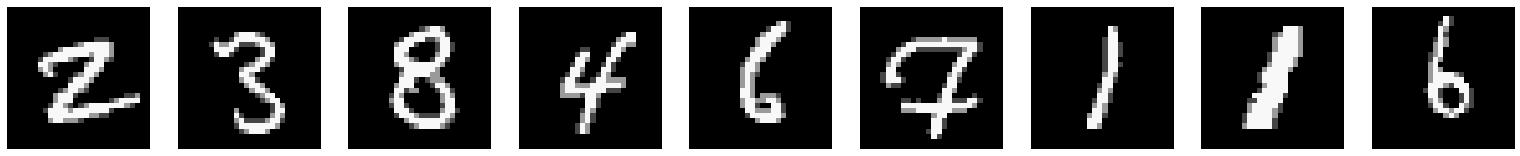

In [8]:
display_colors, display_idxs, *_ = next(iter(ds_train))
if config.grad_accum_steps:
    display_colors,display_idxs = display_colors[0],display_idxs[0]
viz.showSeq(display_colors, display_idxs, config.dataset.image_size, max_images=9)

In [9]:


# model config
config.model = DotMap({
    'n_colors': config.dataset.n_colors,
    'n_color_dims': config.dataset.n_color_dims,
    'image_size': config.dataset.image_size,
    'seq_len': config.dataset.image_size[0] * config.dataset.image_size[1],
    'n_enc_a_layers': 3,
    'n_enc_b_layers': 2,
    'ffl_dim': 800,
    'embd_dim': 512,
    'n_dec_layers': 2,
    'dec_dim': 400,
    'n_heads': 8,
    'dropout_rate': 0.04,
    'use_idxs_input': True,
    'architecture': 'anp',
    'position_embedding': 'pos_enc',
    'activation': 'swish',
})

if config.distributed == False:
    strategy = tf.distribute.get_strategy()
else:
    strategy = tf.distribute.MirroredStrategy()

with strategy.scope():
    model = models.transformer(config.model)
    # Adam params taken from the linked notebook
    optimizer = keras.optimizers.Adam(learning_rate=schedules.learning_rate_schedule(config))

ds_train_dist = strategy.experimental_distribute_dataset(ds_train)

config.training_mode = 'full_combination'

import socket
model_name = models.model_name(socket.gethostname(), config)
print(model_name)

cuda3.sms.vuw.ac.nz-28x28-bs1x1x24


In [ ]:
evaler = training.Evaluator(config, model, optimizer, viz, ds, ds_train_dist, ds_test)

training_loop = training.TrainingLoop(config, evaler, model_name)

In [ ]:


with strategy.scope():
    training_loop.train()

In [ ]:
model.save(f"models/{model_name}")

In [ ]:
evaler.process_batch(show_input=True)
evaler.new_test_batch()
evaler.process_batch(show_input=True)